In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
%matplotlib inline


np.random.seed(1)
N = 200
K = 3
M = 2
T3 = np.zeros((N,3), dtype=np.uint8)
T2 = np.zeros((N,2))
X = np.zeros((N,K))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
# print(np.shape(T3))
# print(T3)
mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1, -0.5]])
sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])
pi = np.array([0.4, 0.8, 1])

for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
#         print(sig[T3[n, : ]== 1, k])
#         T3[n, : ]== 1　は　0,1,2のどれかを返す
        X[n, k] = np.random.randn() * sig[T3[n, : ]== 1, k] + mu[T3[n, :] == 1, k]
        
X[:, M] = 1
# T2[:, 0] = T3[:, 0]
# T2[:,1] = T3[:, 1]
# T2[:,1] = T2[:, 1] + T3[:, 2]

In [2]:
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T3[:X_n_training, :]
T_test = T3[X_n_training:, :]

np.savez("class_data.npz", X_train=X_train, T_train=T_train, X_test=X_test, T_test=T_test, X_range0=X_range0, X_range1=X_range1)

In [3]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

def fnn(wv, M, K, x):
    N, D = x.shape
    w = wv[:M * D]
    w = w.reshape(M, D)
    
    v = wv[M * D:]
    v = v.reshape(K, (M + 1))
    b = np.zeros((N, M +1))
    z = np.zeros((N, M +1))
#     z[:, M] = 1
    a = np.zeros((N, K))
    y = np.zeros((N, K))
    
    for n in range(N):
        for m in range(M):
            b[n, m] = np.dot(w[m, :], x[n, :])
            z[n, m] = sigmoid(b[n,m])
        wkz = 0
        z[n, M] = 1
        
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n,k] = np.exp(a[n,k]) / wkz
    return y, a, z, b

def ce_fnn(wv, M, K,x, t):
    N, D = x.shape
    y, a, z, b = fnn(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce

def dce_fnn_num(wv, M, K, x, t):
    epsilon = 0.001
    # 元の配列と同じ形状の配列を生成する中身はゼロ
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        # 値渡し？
        # ただの代入だと参照渡しといって、元の配列にも影響が出てしまう
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = ce_fnn(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = ce_fnn(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
    return dwv

def fit_fnn_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))

    for i in range(n):
        wvt  = wvt - alpha * dce_fnn_num(wvt, M, K, x_train, t_train)
        err_train[i] = ce_fnn(wvt, M, K, x_train, t_train)
        err_test[i] = ce_fnn(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test

def dce_fnn(wv, M, K, x, t):
    N, D = x.shape
    w = wv[:M * D]
    w = w.reshape(M, D)
    
    v = wv[M * D:]
    v = v.reshape(K, (M + 1))
    
    y, a, z, b = fnn(wv, M, K, x)
    
    dwv = np.zeros_like(wv)
    dw = np.zeros()

In [42]:
WV = np.ones(15)
M = 2
K = 3
ce_fnn(WV,M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

In [49]:
np.shape(X_train)

(100, 2)

143.0352098941803
0.21776875828138353
0.2841594584850213


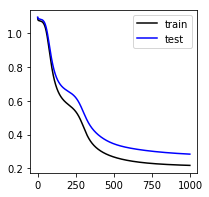

In [52]:
import time
starttime = time.time()
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
# Xavier の初期値 　= 1 / √前層のノード数
W_init_X = np.random.randn(M * 3) / np.sqrt(np.shape(X_train)[1])
V_init_X = np.random.randn(K * (M + 1)) / np.sqrt(M)
WV_init_X = np.r_[W_init_X, V_init_X]

N_step = 1000
alpha = 0.5
WV, WV_hist, Err_train, Err_test = fit_fnn_num(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
ca_time = time.time() - starttime
print(ca_time)
print(Err_train[-1])
print(Err_test[-1])
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, "black", label="train")
plt.plot(Err_test, "blue",label="test")
plt.legend()
plt.show()


In [16]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[1,2,3,4],[4,5,6,7]])
a[0, :].shape

(3,)

In [13]:
np.dot(a[0, :],b[0, :])

ValueError: shapes (3,) and (4,) not aligned: 3 (dim 0) != 4 (dim 0)